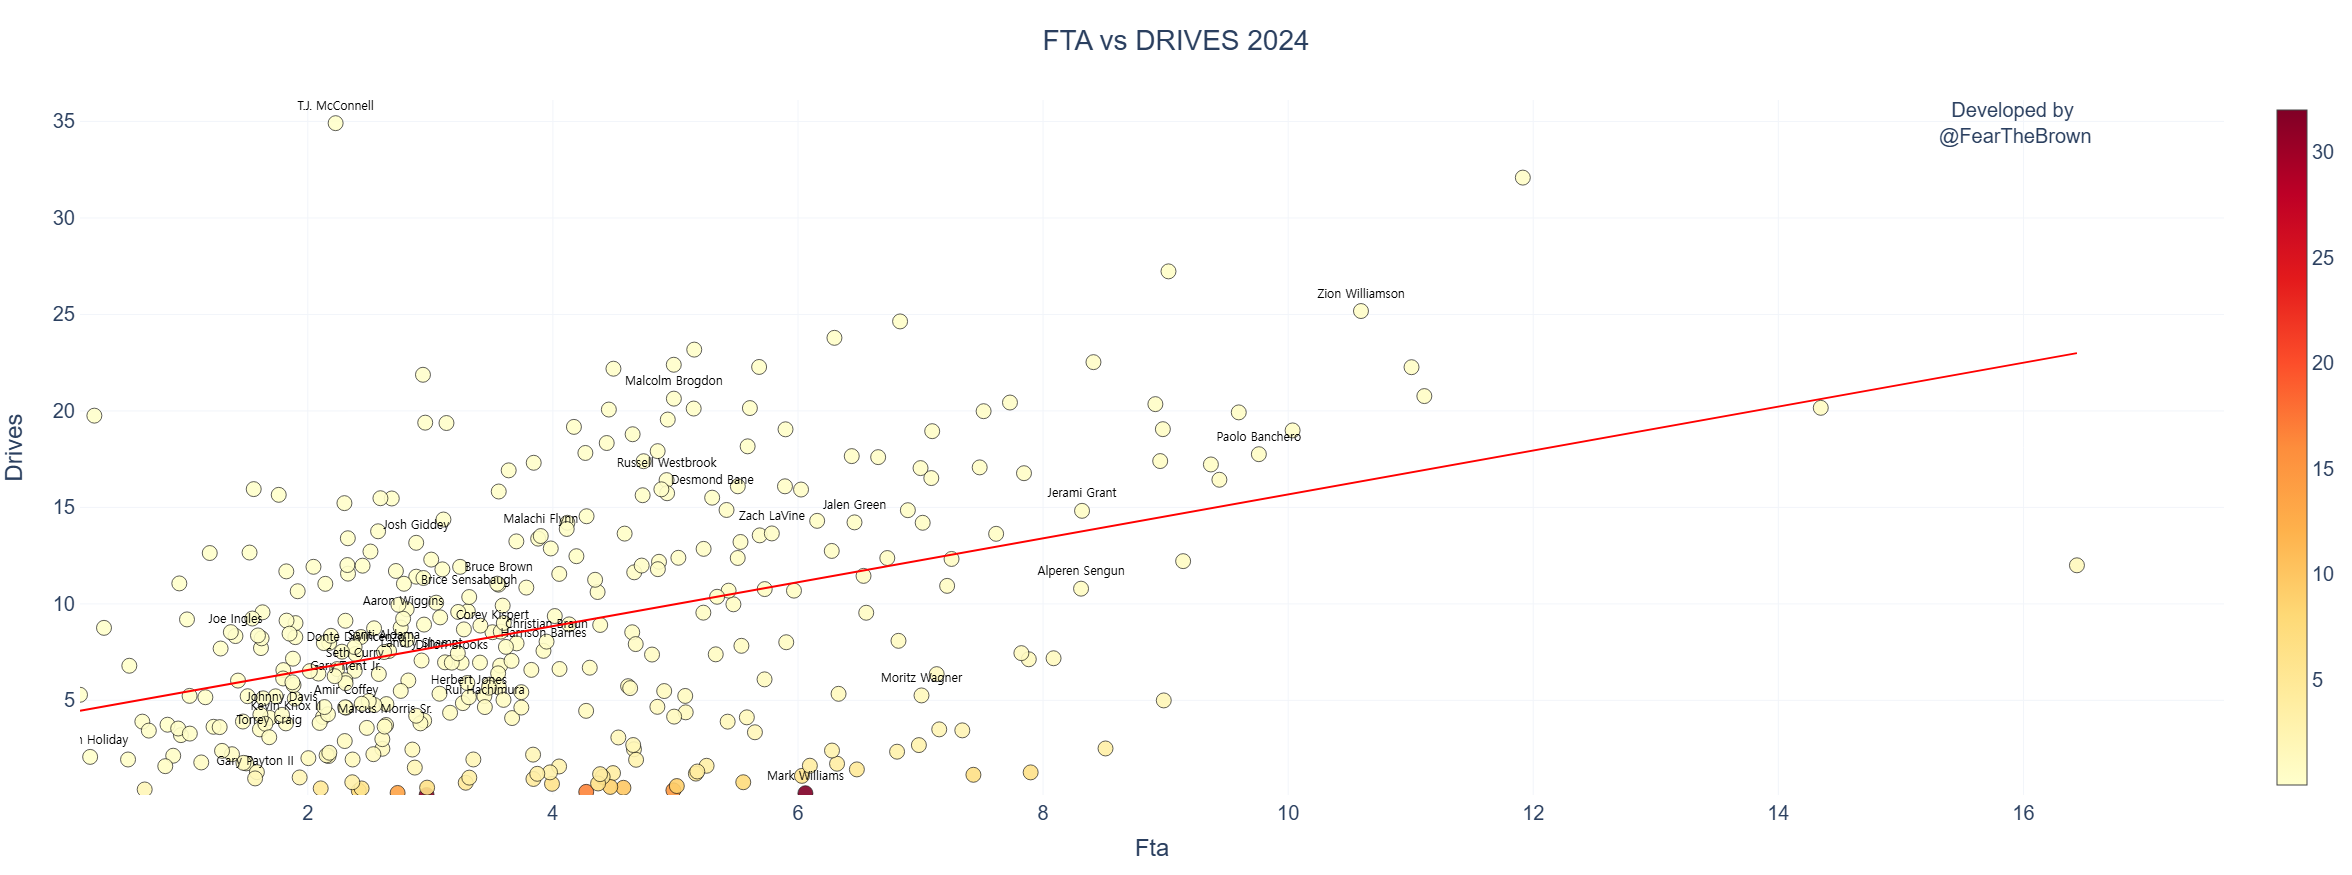

In [17]:
import pandas as pd
import requests
import plotly.graph_objects as go
import math
from scipy import stats
import string
import numpy as np
import time
from scipy.stats import zscore
import sys
import os
import glob
import statsmodels.api as sm

from nba_api.stats.static import players,teams

start_time = time.time()
directory = "data/2025"

# Use glob to find all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, "*.csv"))
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api as sm
from nba_api.stats.static import teams
def column_map():
    column_mapping = {
    "POINTS": "POINTS",
    "True Shooting":"TS_PCT",
    "FGA": "FGA",
    "3PT Attempt": "FG3A",
    "AST": "AST",
    "FTA": "FTA",
    "OREB": "OREB",
    "DREB": "DREB",
    "REB": "REB",
    "TOV": "TOV",
    "STL": "STL",
    "BLK": "BLK",
    "Net Rating": "NET_RATING",
    "Offensive Rating":"OFF_RATING",
    "Defensive Rating":"DEF_RATING",
    "Usage":"Usage",
    "DRIVES": "DRIVES",
    "Drive Points": "DRIVE_PTS",
    "Pull Up Points": "PULL_UP_PTS",
    "Catch and Shoot Points": "CATCH_SHOOT_PTS",
    "3PT%": "FG3_PCT",

    "Catch and Shoot FGA": "CATCH_SHOOT_FGA",
    "Pull Up FGA": "PULL_UP_FGA",
    "Pull Up eFG%": "PULL_UP_EFG_PCT",

    "Pull Up FG3A":"PULL_UP_FG3A",
    "Catch and Shoot FG3A"   :"CATCH_SHOOT_FG3A",

    "Very Tight 3PT Attempt": "very_tight_FG3A",
    "Tight 3PT Attempt": "tight_FG3A",
    "Open 3PT Attempt": "open_FG3A",
    "Wide Open 3PT Attempt": "wide_open_FG3A",
    "Very Tight 3PT Attempt %": "very_tight_FG3_PCT",
    "Tight 3PT Attempt %": "tight_FG3_PCT",
    "Catch and Shoot EFG%": "CATCH_SHOOT_EFG_PCT",
    "Open 3PT%": "open_FG3_PCT",
    "Wide open 3PT%": "wide_open_FG3_PCT",
    "Contested Rebounds":"REB_CONTEST",
    "Adjusted OREB Chance %": "OREB_CHANCE_PCT_ADJ",
    "Adjusted DREB Chance %": "DREB_CHANCE_PCT_ADJ",
    "Potential Assist": "POTENTIAL_AST",
    "Freethrow Assist": "FT_AST",
    "Made Passes": "PASSES_MADE",
    "Passes Received": "PASSES_RECEIVED",
    "Touches": "TOUCHES",
    "Average Seconds Per Touch": "AVG_SEC_PER_TOUCH",
    "Average Dribble Per Touch": "AVG_DRIB_PER_TOUCH",
    "Time Of Possession": "TIME_OF_POSS",
    "AtRimFG3AFrequency": "AtRimFG3AFrequency",
    "LiveBallTurnovers": "LiveBallTurnovers",
    "BadPassTurnovers": "BadPassTurnovers",
    "Travels": "Travels",
    "BadPassSteals": "BadPassSteals",
     "Offensive Fouls Drawn":"Offensive Fouls Drawn",
    "LiveBallTurnoverPct": "LiveBallTurnoverPct",
    "Charge Fouls Drawn": "Charge Fouls Drawn",
    "AtRimPctAssisted": "AtRimPctAssisted",
    "BlockedAtRim": "BlockedAtRim",
    "AtRimAssists": "AtRimAssists",
    "SecondChanceAtRimFGA": "SecondChanceAtRimFGA",
    "AtRimFGA": "AtRimFGA",
    "AtRimAccuracy": "AtRimAccuracy",
    "SecondChanceFG2A": "SecondChanceFG2A",
    "PtsUnassisted2s": "PtsUnassisted2s",
    "PtsUnassisted3s": "PtsUnassisted3s",
    "ABOVE_BREAK_3_FGA": "ABOVE_BREAK_3_FGA",
    "ABOVE_BREAK_3_FG_PCT": "ABOVE_BREAK_3_FG_PCT"
    
    }

    return column_mapping
def graph_scatter(column1, column2, year, ps=False, mpg=10, gp=10, selected_rate='Per 100', team=None, team_list=[], remap={}):
    # File path adjusted for team-level data
    trail = '_ps' if ps else ''
    file_path = 'https://raw.githubusercontent.com/gabriel1200/player_sheets/refs/heads/master/team_totals/'
    link = file_path + str(year) + trail + '_team_totals.csv'

    # Relevant columns for team-level analysis
    columns_to_read = [column1, column2, 'POSS', 'GP', 'TEAM_ABBREVIATION', 'MIN']
    df = pd.read_csv(link, usecols=columns_to_read)

    # Drop missing data and calculate MPG
    df.dropna(subset=[column1, column2], inplace=True)
    df['MPG'] = df['MIN'] / df['GP']
    df = df[df.MPG >= mpg]
    df = df[df.GP >= gp]

    # Set default dot size and color
    df['size'] = 15
    dot_color = '#3e8989'
    dot_color_highlight = '#ffdb58'
    df['color'] = dot_color

    # Adjust percentages if applicable
    if any(keyword in column1.lower() for keyword in ['freq', 'accur', 'pct', '%']):
        df[column1] *= 100
    if any(keyword in column2.lower() for keyword in ['freq', 'accur', 'pct', '%']):
        df[column2] *= 100

    # Handle rate adjustments
    if selected_rate == 'Per 100':
        if not any(keyword in column1.lower() for keyword in ['freq', 'accur', 'pct', '%', 'rating', 'usage']):
            df[column1] = 100 * df[column1] / df.POSS
        if not any(keyword in column2.lower() for keyword in ['freq', 'accur', 'pct', '%', 'rating', 'usage']):
            df[column2] = 100 * df[column2] / df.POSS
    elif selected_rate == 'Per Game':
        if not any(keyword in column1.lower() for keyword in ['freq', 'accur', 'pct', '%', 'rating', 'usage']):
            df[column1] = df[column1] / df.GP
        if not any(keyword in column2.lower() for keyword in ['freq', 'accur', 'pct', '%', 'rating', 'usage']):
            df[column2] = df[column2] / df.GP

    # Highlight specific team
    df['opa'] = 0.6  # Default opacity
    if team:
        df.loc[df['TEAM_ABBREVIATION'] == team, 'color'] = dot_color_highlight
        df.loc[df['TEAM_ABBREVIATION'] == team, 'size'] = 25
        df.loc[df['TEAM_ABBREVIATION'] == team, 'opa'] = 1

    # Highlight specific teams in team_list
    if team_list:
        dot_color_team = '#ff7f7f'
        df.loc[df['TEAM_ABBREVIATION'].isin(team_list), 'color'] = dot_color_team
        df.loc[df['TEAM_ABBREVIATION'].isin(team_list), 'size'] = 30
        df.loc[df['TEAM_ABBREVIATION'].isin(team_list), 'opa'] = 1

    # Title setup
    pstring = 'Playoffs' if ps else 'RS'
    title_text = f"{year} {pstring}<br>{remap.get(column2, column2)} vs {remap.get(column1, column1)} {selected_rate}"

    # Hover text for teams
    hover_text = (
        "Team: " + df["TEAM_ABBREVIATION"] +
        f"<br>{column1}: " + df[column1].round(1).astype(str) +
        f"<br>{column2}: " + df[column2].round(1).astype(str)
    )

    # Set axis ranges
    x_min, x_max = df[column1].min(), df[column1].max()
    y_min, y_max = df[column2].min(), df[column2].max()

    # Scatter Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df[column1],
        y=df[column2],
        mode='markers+text',
        text=df['TEAM_ABBREVIATION'],  # Show team abbreviation
        hovertext=hover_text,
        textposition="bottom center",
        showlegend=False,
        marker=dict(
            color=df['color'],
            opacity=df['opa'],
            line=dict(color='white', width=0.3),
            size=df['size'],
        ),
        textfont=dict(
            family="Malgun Gothic",
            size=18,
            color=dot_color_highlight
        )
    ))

    # Trendline
    X = sm.add_constant(df[column1])
    model = sm.OLS(df[column2], X).fit()
    trendline = model.predict(X)
    fig.add_trace(go.Scatter(
        x=df[column1],
        y=trendline,
        mode='lines',
        name='Trendline',
        line=dict(color='purple'),
        showlegend=False
    ))

    # Layout configuration
    fig.update_layout(
        width=1225,
        height=875,
        xaxis_range=[x_min - 1, x_max + 1.2],
        yaxis_range=[y_min - 1, y_max + 1.2],
        title=title_text,
        title_x=0.5,
        autosize=True,
        paper_bgcolor='#1a1a1a',
        plot_bgcolor='#1a1a1a',
        font=dict(family="Malgun Gothic", size=20, color='white'),
        annotations=[dict(
            showarrow=False,
            text='@GabeLeftBrain',
            x=x_max - 0.5,
            y=y_max
        )]
    )

    # Update axes titles
    fig.update_xaxes(title_text=remap.get(column1, column1), showline=False, gridcolor='#f2f5fa', showgrid=False)
    fig.update_yaxes(title_text=remap.get(column2, column2), showline=False, gridcolor='#f2f5fa', showgrid=False)

    return fig

fig=graph_scatter('FTA','DRIVES',2025,remap=column_map())
fig.show()